# Test notebook evaluating different optical flow methods and parameters on PredNet-predicted video frames
begun 24.11.2021

In [4]:
import numpy as np
import cv2
import itertools
import csv
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

## Load two frames

In [338]:
img1 = cv2.imread('./example_images/bk_gradient1.jpg')
img2 = cv2.imread('./example_images/bk_gradient2.jpg')

img1 = cv2.resize(img1, (160,120))
img2 = cv2.resize(img2, (160,120))

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

## Alternatively, create two frames with moving blurry blobs
Might be helpful while exploring which optic flow methods handle blurry motion better

In [339]:
# define normalized 2D gaussian
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

In [340]:
# create a 2D grid of the right image dimensions (160x120)
x = np.linspace(-5, 5, 160)
y = np.linspace(-5, 5, 120)
x, y = np.meshgrid(x, y)

# create two images with a gaussian blob in two slightly different locations 
# mx and my control mean (i.e. location) in x and y dimensions
# sx and sy control standard deviation (i.e. spread) in x and y dimensions

# Our stimuli tend to move as well as getting blurrier, so let's simulate that:
img1_gray = gaus2d(x, y, mx=-3, my=-3, sx=0.3, sy=0.3)
img2_gray = gaus2d(x, y, mx=-2, my=-3, sx=0.4, sy=0.4)

# Scale and set datatype to be compatible with cv2
img1_gray = cv2.normalize(img1_gray, None, 0, 255, cv2.NORM_MINMAX)
img2_gray = cv2.normalize(img2_gray, None, 0, 255, cv2.NORM_MINMAX)

img1_gray = img1_gray.astype(np.uint8)
img2_gray = img2_gray.astype(np.uint8)

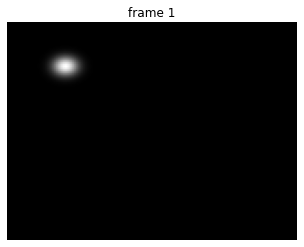

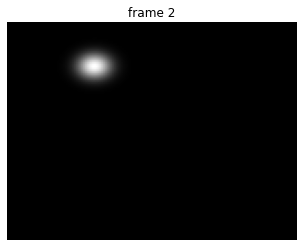

In [341]:
plt.imshow(img1_gray, cmap='gray')
plt.axis('off')
plt.title('frame 1')
plt.show()

plt.imshow(img2_gray, cmap='gray')
plt.axis('off')
plt.title('frame 2')
plt.show()

## Lukas-Kanade

In [342]:
# define points to track

# option 1: as in optical_flow.py code
# cv2.goodFeaturesToTrack

# option 2: track all pixels
grid_y, grid_x = np.mgrid[0:img1_gray.shape[0]:1, 0:img1_gray.shape[1]:1]
p0 = np.stack((grid_x.flatten(),grid_y.flatten()),axis=1).astype(np.float32)

In [343]:
# Lukas-Kanade
# required arguments = im1, im2, previous_points, next_points
p1, status, error = cv2.calcOpticalFlowPyrLK(img1_gray, img2_gray, p0, None)
flow = p1-p0

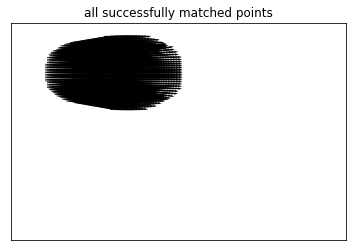

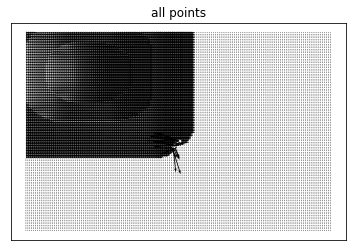

In [344]:
# plot as arrows

mask_array = status==1
mask_array = mask_array.flatten()
plt.quiver(p0[:,0],p0[:,1],0.0*flow[:,0],0.0*flow[:,1])
plt.quiver(p0[mask_array,0],p0[mask_array,1],flow[mask_array,0],flow[mask_array,1], angles='xy', scale_units='xy', scale=0.7)
plt.xticks([], [])
plt.yticks([], [])
ax = plt.gca()
ax.invert_yaxis() # for unclear reasons, quiver plots flip the y axis relative to the original image
plt.title('all successfully matched points')
plt.show()

plt.quiver(p0[:,0],p0[:,1],flow[:,0],flow[:,1])
plt.xticks([], [])
plt.yticks([], [])
ax = plt.gca()
ax.invert_yaxis() # for unclear reasons, quiver plots flip the y axis relative to the original image
plt.title('all points')
plt.show()

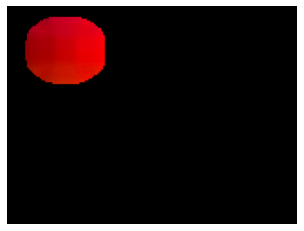

In [345]:
# plot as colours
# nb this only plots the points for which correspondences were successfully found

flow_img = np.reshape(flow, [img1_gray.shape[0],img1_gray.shape[1],2])
mask_img = np.reshape(mask_array, [img1_gray.shape[0],img1_gray.shape[1]])

# crate HSV & make Saturation a constant
hsv = np.zeros([img1_gray.shape[0],img1_gray.shape[1],3], dtype=np.uint8)
hsv[..., 1] = 255

# Encoding: convert the algorithm's output into Polar coordinates
mag, ang = cv2.cartToPolar(flow_img[..., 0], flow_img[..., 1])
mag[mask_img==False]=0 # remove entries for pixels where no successful correspondence was found
                             # doing this before normalisation stage ensures visible pixels use full Value range
# Use Hue and Value to encode the Optical Flow
hsv[..., 0] = ang * 180 / np.pi / 2
hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

# remove entries for pixels where no successful correspondence was found
hsv[mask_img==False]=[0,0,0]

# Convert HSV image into BGR for demo
rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
plt.imshow(rgb)
plt.axis('off')
plt.show()

## DualTVL1OpticalFlow

In [346]:
# DualTVL1OpticalFlow
# required arguments = im1, im2, next_points
optical_flow = cv2.DualTVL1OpticalFlow_create()
flow_img = optical_flow.calc(img1_gray, img2_gray, None)

In [347]:
# get pixel locations for plotting
grid_y, grid_x = np.mgrid[0:img1_gray.shape[0]:1, 0:img1_gray.shape[1]:1]
p0 = np.stack((grid_x.flatten(),grid_y.flatten()),axis=1).astype(np.float32)
flow = np.reshape(flow_img, p0.shape)

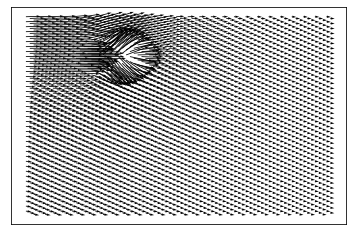

In [348]:
# plot as arrows

# here we have flow data for all points; for easier visibility let's only plot every Nth pixel though
plot_nth = 6
plt.quiver(p0[0::plot_nth,0],p0[0::plot_nth,1],flow[0::plot_nth,0],flow[0::plot_nth,1], angles='xy', scale_units='xy', scale=0.7)
plt.xticks([], [])
plt.yticks([], [])
ax = plt.gca()
ax.invert_yaxis() # for unclear reasons, quiver plots flip the y axis relative to the original image
plt.show()

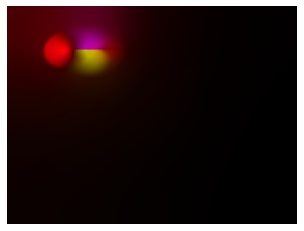

In [349]:
# plot as colours

# crate HSV & make Value a constant (?)
hsv = np.zeros([img1_gray.shape[0],img1_gray.shape[1],3], dtype=np.uint8)
hsv[..., 1] = 255

# Encoding: convert the algorithm's output into Polar coordinates
mag, ang = cv2.cartToPolar(flow_img[..., 0], flow_img[..., 1])
# Use Hue and Value to encode the Optical Flow
hsv[..., 0] = ang * 180 / np.pi / 2
hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

# Convert HSV image into BGR for demo
rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
# plt.imshow(img1)
plt.imshow(rgb)
plt.axis('off')
plt.show()

nb could be helpful to combine both visualisation methods, to plot coloured arrows